# Credit Card Fraud Detection
#### Garrett Lappe
#### Data comes from Kaggle: https://www.kaggle.com/mlg-ulb/creditcardfraud

In [20]:
import pandas as pd

In [21]:
input_file_path = 'fraud_data.csv'

df = pd.read_csv(input_file_path)
del df['Time']  # Time field only increments, not very useful especially since we have no variables to track across time

In [22]:
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Features are masked, all data is numeric so we don't need to encode anything.

In [23]:
df.dtypes

V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object

### Class imbalance

In [24]:
df.groupby('Class').size()

Class
0    284315
1       492
dtype: int64

In [25]:
df.groupby('Class').size() / len(df)

Class
0    0.998273
1    0.001727
dtype: float64

Over 99.8% of the data we have is class 0 -- NOT FRAUD.

Imbalanced data introduces a challenge to many machine learning techniques due to the tendency for the classifier to simply label *everything* as the majority class.

In this situation, labeling everything 0 would give us an amazing 99.8% accuracy! However, the classification performance *on each class* is important, and labeling everything 0 would mean we'd completely miss all the fraud cases.

### Handling imbalanced data -- over/under sampling

We can adjust the class distribution of our training data by oversampling minority (fraud) class, or by under-sampling the majority (non-fraud) class.

The end result of each technique is a training set with more even class distributions, which prevents the model from lazily defaulting to the majority class.

### Moving forward

If we were to under-sample non-fraud to achieve a 50-50 split with 492 class 1 and 492 class 0, this data set may not be large enough to sufficiently train any models on.

Additionally, we would be excluding a LOT of non-fraud transactions, so our classifier would likely miss out on many features/patterns in that 99.6% of left-out data.

As such, I've decided to proceed with over-sampling to create a training dataset.

### Make train-test split

Remember, we only want to oversample with the TRAINING dataset.

The test/validation data should be representative of what the actual population is--so we'll keep the imbalance there.

In [26]:
from sklearn.model_selection import train_test_split

In [28]:
labels = df['Class']
df.drop(columns='Class', axis=1, inplace=True)  # data is left with features only

X_train, X_test, y_train, y_test = train_test_split(df, labels, stratify=labels, random_state=18)
assert len(X_train)==len(y_train)  # checking for myself that I unpacked the variables correctly!

### Oversampling

In [29]:
from imblearn.over_sampling import SMOTE

In [30]:
sampler = SMOTE(sampling_strategy='auto', random_state=18, k_neighbors=5)

In [34]:
len(y_train)  # original train dataset size

213605

In [35]:
sum(y_train)  # number of fraud cases in original train dataset

369

In [33]:
X_train_rs, y_train_rs = sampler.fit_resample(X_train, y_train)

In [36]:
len(y_train_rs)  # new train dataset size

426472

In [38]:
sum(y_train_rs) / len(y_train_rs)  # proportion of new train dataset labeled as fraud

0.5

# LightGBM

### Base Model Creation

In [39]:
import lightgbm as lgb
from lightgbm import cv, Dataset

In [41]:
# another train-test-split within the train dataset
train_dataset = Dataset(X_train_rs, y_train_rs, free_raw_data=False)  # keep original X_train_rs and y_train_rs
test_dataset = Dataset(X_test, y_test, free_raw_data=False)  # keep original X_test and y_test

In [42]:
param = {'num_leaves': 31, 
         'objective': 'binary',
         'metric':'auc'}

In [45]:
bst = lgb.train(param, train_dataset, 100, valid_sets=[test_dataset])

[1]	valid_0's auc: 0.953324
[2]	valid_0's auc: 0.95206
[3]	valid_0's auc: 0.957489
[4]	valid_0's auc: 0.955543
[5]	valid_0's auc: 0.956275
[6]	valid_0's auc: 0.956993
[7]	valid_0's auc: 0.965282
[8]	valid_0's auc: 0.96564
[9]	valid_0's auc: 0.965528
[10]	valid_0's auc: 0.964598
[11]	valid_0's auc: 0.964211
[12]	valid_0's auc: 0.962485
[13]	valid_0's auc: 0.963229
[14]	valid_0's auc: 0.96269
[15]	valid_0's auc: 0.963021
[16]	valid_0's auc: 0.964777
[17]	valid_0's auc: 0.964842
[18]	valid_0's auc: 0.964748
[19]	valid_0's auc: 0.965872
[20]	valid_0's auc: 0.966563
[21]	valid_0's auc: 0.967233
[22]	valid_0's auc: 0.966815
[23]	valid_0's auc: 0.967446
[24]	valid_0's auc: 0.967493
[25]	valid_0's auc: 0.967448
[26]	valid_0's auc: 0.967
[27]	valid_0's auc: 0.966443
[28]	valid_0's auc: 0.966108
[29]	valid_0's auc: 0.965726
[30]	valid_0's auc: 0.966346
[31]	valid_0's auc: 0.96631
[32]	valid_0's auc: 0.96603
[33]	valid_0's auc: 0.965727
[34]	valid_0's auc: 0.965732
[35]	valid_0's auc: 0.965395
[3

##### Base model precision and recall

In [46]:
from sklearn.metrics import precision_score, recall_score, accuracy_score

In [47]:
y_pred = bst.predict(X_test)
y_pred[:10]

array([2.47675833e-04, 1.09144672e-03, 2.27556613e-04, 1.18857788e-04,
       7.60423365e-05, 1.56942606e-04, 2.48900993e-03, 5.29986869e-04,
       9.20436583e-05, 2.49877476e-03])

In [49]:
y_pred_classes = [1 if p>= 0.5 else 0 for p in y_pred]
print('Number of predictions made:', len(y_pred))
print('Number of transactions predicted to be fraud:', sum(y_pred_classes))
print('Number of actual fraud cases:', sum(y_test))

Number of predictions made: 71202
Number of transactions predicted to be fraud: 130
Number of actual fraud cases: 123


#### Precision - if we say it's fraud, how often did it actually turn out to be fraud?

In [56]:
base_precision = precision_score(y_pred=y_pred_classes, y_true=y_test)
print('Base model precision score: {}'.format(round(base_precision,4)))  # proportion of cases we labeled fraud that ARE fraud

Base model precision score: 0.7385


#### Recall - how good were we at identifying actual fraud when it occurs?

In [57]:
base_recall = recall_score(y_pred=y_pred_classes, y_true=y_test)
print('Base model recall score: {}'.format(round(base_recall,4)))  # proportion of fraud cases we labeled as fraud

Base model recall score: 0.7805


#### Accuracy - overall results

In [119]:
print('Base accuracy: {}'.format(round(accuracy_score(y_pred=y_pred_classes, y_true=y_test),4)))

Base accuracy: 0.9991


### In depth - RandomizedSearchCV

Search through a number of parameter value combinations to find configurations that out-perform the base model

In [61]:
import numpy as np

In [68]:
param_grid = {'num_leaves': [15, 31, 55, 87, 131, 221],
              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
              'bagging_fraction': [.6, .8, 1.0],
              'feature_fraction': [.6, .8, 1.0]}
num_param_options = [len(param_grid[p]) for p in param_grid]
num_combos = np.prod(num_param_options)
num_combos

486

In [59]:
from lightgbm import LGBMClassifier

In [60]:
from sklearn.model_selection import RandomizedSearchCV

In [69]:
est = LGBMClassifier()
clf = RandomizedSearchCV(est, param_distributions=param_grid, n_iter=50, n_jobs=-1, verbose=2)

In [70]:
clf.fit(X_train_rs, y_train_rs)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  98 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  3.8min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, s...
                                            subsample_for_bin=200000,
                                            subsample_f

#### Best-performing model paramters:

In [71]:
clf.best_params_

{'num_leaves': 221,
 'min_child_weight': 0.001,
 'feature_fraction': 0.8,
 'bagging_fraction': 0.6}

#### RandomizedSearchCV - best model evaluataion

In [77]:
y_pred = clf.best_estimator_.predict(X_test)
print('Number of predictions made:', len(y_pred))
print('Number of transactions predicted to be fraud:', sum(y_pred))
print('Number of actual fraud cases:', sum(y_test))

Number of predictions made: 71202
Number of transactions predicted to be fraud: 112
Number of actual fraud cases: 123


In [78]:
rs_precision = precision_score(y_pred=y_pred, y_true=y_test)
print('RandomizedSearchCV best model precision score: {}'.format(round(rs_precision,4)))

RandomizedSearchCV best model precision score: 0.875


In [79]:
rs_recall = recall_score(y_pred=y_pred, y_true=y_test)
print('RandomizedSearchCV best model recall score: {}'.format(round(rs_recall,4)))

RandomizedSearchCV best model recall score: 0.7967


In [92]:
from sklearn.metrics import roc_auc_score

In [96]:
y_pred_p = clf.best_estimator_.predict_proba(X_test)
y_pred_p[0]

array([9.99972022e-01, 2.79776534e-05])

#### Final ROC_AUC_Score

In [120]:
y_pred_scores = [p[1] for p in y_pred_p]
round(roc_auc_score(y_score=y_pred_scores, y_true=y_test),4)

0.9677

### Summary

In [100]:
print('Comparing base to RandomizedSearchCV best model')
print('Base Precision: {}\tRSCV Precision: {}'.format(round(base_precision,4),round(rs_precision,4)))
print('Base Recall: {}\tRSCV Recall: {}'.format(round(base_recall,4),round(rs_recall,4)))

Comparing base to RandomizedSearchCV best model
Base Precision: 0.7385	RSCV Precision: 0.875
Base Recall: 0.7805	RSCV Recall: 0.7967


In [81]:
print('RandomizedSearchCV: Precision improvement: {}'.format(round(rs_precision - base_precision, 4)))
print('RandomizedSearchCV: Recall improvement: {}'.format(round(rs_recall - base_recall, 4)))

RandomizedSearchCV: Precision improvement: 0.1365
RandomizedSearchCV: Recall improvement: 0.0163


In [89]:
print('Precision is {}% higher than base'.format(round(100*((rs_precision - base_precision)/base_precision),2)))

Precision is 18.49% higher than base


In [90]:
print('Recall is {}% higher than base'.format(round(100*((rs_recall - base_recall)/base_recall),2)))

Recall is 2.08% higher than base


In [117]:
print('Final accuracy: {}'.format(round(accuracy_score(y_pred=y_pred, y_true=y_test),4)))

Final accuracy: 0.9995


By over-sampling the fraud class for the training dataset, we were able to create a larger, more balanced dataset.

We evaluated the model on the original, imbalanced class distribution.

Using RandomizedSearchCV, we cross-validated 50 different parameter combinations to find a model that out-performed the base model.

Precision was increased significantly (fewer false positives), recall improved slightly (more true positives).

ROC AUC score was improved from .952 to .968

### Visualizing Performance

In [102]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

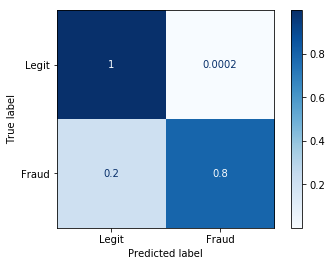

In [114]:
disp = plot_confusion_matrix(clf.best_estimator_, X_test, y_test,
                             display_labels=['Legit','Fraud'],
                             cmap=plt.cm.Blues,
                             normalize='true')
plt.show()